# Optimizing the Image Sampling

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

## Introduction

This example was written to help users better understand the subtleties in improving image sampling for dithered data. One of the powers of the *drizzling* algorithm is that, given properly dithered images, it can restore much of the information lost due to undersampled images ([Fruchter and Hook, 2002](http://iopscience.iop.org/article/10.1086/338393/pdf)). 

This work is based on [ISR ACS 2015-01](http://www.stsci.edu/hst/acs/documents/isrs/isr1501.pdf), which contains a more detailed discussion than presented here.

In practice, this requires the use of `Astrodrizzle` task within the *Drizzlepac* package. This example will cover the following topics:

    1. Description of the Data
    2. Run astrodrizzle several times using different settings for the 'final_pixfrac' and 'final_scale' parameters
    3. Compare and evaluate results of using different 'final_pixfrac' and 'final_scale' values

In [1]:
import glob
import shutil
import os

from astropy.io import fits
from astroquery.mast import Observations
from astropy.visualization import LogStretch,ImageNormalize,LinearStretch
from astropy import wcs
import drizzlepac
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


## 1. Description of the data
Four images of the spiral galaxy NGC 3370 (Program 11570) were acquired using the WFC3/IR F160W imaging filter. The `WFC3-IR-DITHERBOX-MIN` dither pattern designed to provide optimal sampling of the PSF was used.

Data are downloaded using the `astroquery` API to access the [MAST](http://archive.stsci.edu) archive. The `astroquery.mast` [documentation](http://astroquery.readthedocs.io/en/latest/mast/mast.html) has more examples for how to find and download data from MAST. For this example, the caibrated FLT exposures from visit 19 will be downloaded.

In [2]:
# Querying MAST and downloading files.
obs_ids = ['ib1f19010']
obs_table = Observations.query_criteria(obs_id=obs_ids, obstype='all')

download_tab = Observations.download_products(obs_table['obsid'], mrp_only=False, productSubGroupDescription=['FLT'])

 [Done]


 [Done]


 [Done]


 [Done]


In [3]:
# Cleaning up directories after dowloading from MAST
for file in download_tab['Local Path']:
    os.rename(file, os.path.basename(file))
        
shutil.rmtree('mastDownload')

## 2. Dithering
For the *drizzle* algorithm to work optimally, observations need to be dithered so that the PSF is optimally sampled. The code below creates plots to show the dithering of each of the images in the association. The plot on the left shows how the images were dithered on the sky (the POSTARG). The plot on the right shows how the offsets translate to pixel phase (e.g. subpixel position). 

Plate scale: 0.1283


Text(0, 0.5, 'Y pixel phase')

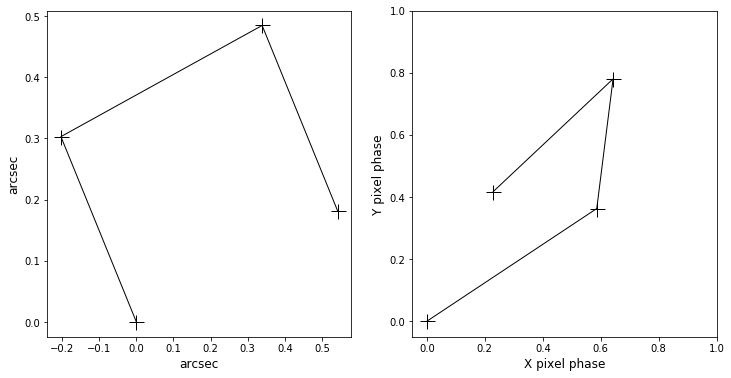

In [4]:
flt_files = glob.glob('*flt.fits')

plate_scale = fits.getval(flt_files[0], 'idcscale',ext=1)
print('Plate scale: {:>6.4f}'.format(plate_scale))
postarg1 = np.empty(len(flt_files), dtype=np.float)
postarg2 = np.empty(len(flt_files), dtype=np.float)
x_phase = np.empty(len(flt_files), dtype=np.float)
y_phase = np.empty(len(flt_files), dtype=np.float)

for i, im in enumerate(flt_files):
    with fits.open(im) as hdu:
        postarg1[i] = hdu[0].header['postarg1']
        postarg2[i] = hdu[0].header['postarg2']
        x_phase[i] = abs(np.modf(postarg1[i] / plate_scale)[0])
        y_phase[i] = abs(np.modf(postarg2[i] / plate_scale)[0])
        
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(postarg1, postarg2, 'k+-', ms=15, lw=1)
ax[0].set_xlabel('arcsec', fontsize='large')
ax[0].set_ylabel('arcsec', fontsize='large')

ax[1].plot(x_phase, y_phase, 'k+-', ms=15, lw=1)
ax[1].set_xlim(-0.05, 1)
ax[1].set_ylim(-0.05, 1)
ax[1].set_xlabel('X pixel phase', fontsize='large')
ax[1].set_ylabel('Y pixel phase', fontsize='large')

## 3. Drizzling
Before drizzling can be performed, a plate scale for the output image should be chosen. This will usually be dictated by the science needs. In theory, critical sampling of a PSF occurs with 2.355 pixels. The FWHM of the WFC3/IR detector at 1600 nm is ~0.151" (Table 7.5 of [WFC Instrument Handbook](http://www.stsci.edu/hst/wfc3/documents/handbooks/currentIHB/c07_ir07.html)). Using these values, a plate scale of 0.065"/pix will be selected for the drizzled output frame, approximately half of the native plate scale (0.1283"/pix). 

The mechanism by which the *drizzle* algorithm improves sampling in the output image is by shrinking the input pixels before adding them to the output pixel grid (see Figure 2 in [Fruchter and Hook (2002)](http://iopscience.iop.org/article/10.1086/338393/pdf)). In practice this process is controlled in the `AstroDrizzle` package by adjusting the `final_pixfrac` parameter, which is the fractional size of the pixel to be used. 
Below `AstroDrizzle` is called twice. The first time, no changes are made to the plate scale or the size of the drop. In the second call, the plate scale and pixfrac are reduced. For a four point dither stack, a `final_pixfrac` value of 0.8 is usually optimal.

In [5]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits',
                                     output='f160w_noopt',
                                     runfile='',
                                     context=False,
                                     build=True,
                                     preserve=False,
                                     clean=True,
                                     driz_sep_bits='64,512',
                                     final_bits='64,512',
                                     final_wcs=True,
                                     final_rot=0.)

drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits',
                                     output='f160w_opt',
                                     runfile='',
                                     context=False,
                                     build=True,
                                     preserve=False,
                                     clean=True,
                                     driz_sep_bits='64,512',
                                     final_bits='64,512',
                                     final_pixfrac=0.8,
                                     final_wcs=True,
                                     final_rot=0.,
                                     final_scale=0.065)

No trailer file created...
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 14:17:09.15 (30/04/2019)

==== Processing Step  Initialization  started at  14:17:09.155 (30/04/2019)


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 591.9026595892853  535.7285496225965  
CD1_1 CD1_2  : -3.5625000794728566e-05  1.3295406620036095e-22  
CD2_1 CD2_2  : 2.8069974210710317e-23  3.5625000794728566e-05  
NAXIS : 1184  1072
********************************************************************************
*
*  Estimated memory usage:  up to 89 Mb.
*  Output image size:       1184 X 1072 pixels. 
*  Output image file:       ~ 14 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  14:17:09.978 (30/04/2019)

==== Processing Step  Static Mask  started at  14:17:09.978 (30/04/2019)
==== Processing Step  Static Mask  finished at  14:17:10.102 (30/04/2019)

==== Processing Step  Subtract Sky  started at  14:17:10.103 (30/04/2019)


***** skymatch started on 2019-04-30 14:17:10.222048
      Version 1.0.2 (2019-03-07 00:54:44 -0500)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ib1f19l6q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l6q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l7q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l7q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l9q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l9q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19laq_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19laq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lowe

   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.712918556912335 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.850577   NEW MDRIZSKY = 0.850577
   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.423691463982195 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.84582   NEW MDRIZSKY = 0.84582
***** skymatch ended on 2019-04-30 14:17:10.514810
TOTAL RUN TIME: 0:00:00.292762
==== Processing Step  Subtract Sky  finished at  14:17:10.606 (30/04/2019)

==== Processing Step  Separate Drizzle  started at  14:17:10.607 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305538169e-05  3.723829036815852e-06  
CD2_1 CD2_2  : 3.723829036815852e-06  3.542984305538169e-05  
NAXIS : 1089  963


-Generating simple FITS output: ib1f19l6q_single_sci.fits


-Generating simple FITS output: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19l6q_single_sci.fits


Writing out image to disk: ib1f19l9q_single_sci.fits


-Generating simple FITS output: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19l6q_single_wht.fits


-Generating simple FITS output: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19l9q_single_wht.fits


Writing out image to disk: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19l7q_single_wht.fits


Writing out image to disk: ib1f19laq_single_wht.fits


==== Processing Step  Separate Drizzle  finished at  14:17:11.695 (30/04/2019)

==== Processing Step  Create Median  started at  14:17:11.69 (30/04/2019)
reference sky value for image 'ib1f19l6q_flt.fits' is 465.7527079860748
reference sky value for image 'ib1f19l7q_flt.fits' is 438.310363378517
reference sky value for image 'ib1f19l9q_flt.fits' is 427.78636529492377
reference sky value for image 'ib1f19laq_flt.fits' is 425.39378312624893


Saving output median image to: 'f160w_noopt_med.fits'
==== Processing Step  Create Median  finished at  14:17:12.595 (30/04/2019)

==== Processing Step  Blot  started at  14:17:12.596 (30/04/2019)
    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step  Blot  finished at  14:17:14.464 (30/04/2019)

==== Processing Step  Driz_CR  started at  14:17:14.465 (30/04/2019)


Creating output :  ib1f19l6q_sci1_crmask.fits


Creating output :  ib1f19l7q_sci1_crmask.fits


Creating output :  ib1f19l9q_sci1_crmask.fits


Creating output :  ib1f19laq_sci1_crmask.fits


==== Processing Step  Driz_CR  finished at  14:17:15.622 (30/04/2019)

==== Processing Step  Final Drizzle  started at  14:17:15.665 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 591.9026595892853  535.7285496225965  
CD1_1 CD1_2  : -3.5625000794728566e-05  1.3295406620036095e-22  
CD2_1 CD2_2  : 2.8069974210710317e-23  3.5625000794728566e-05  
NAXIS : 1184  1072


-Generating multi-extension output file:  f160w_noopt_drz.fits
Writing out to disk: f160w_noopt_drz.fits
==== Processing Step  Final Drizzle  finished at  14:17:18.145 (30/04/2019)


AstroDrizzle Version 2.2.6 is finished processing at 14:17:18.146 (30/04/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.8232 sec.
            Static Mask          0.1238 sec.
           Subtract Sky          0.5036 sec.
       Separate Drizzle          1.0890 sec.
          Create Median          0.8995 sec.
                   Blot          1.8686 sec.
                Driz_CR          1.1577 sec.
          Final Drizzle          2.4804 sec.
   ====================          ====================
                  Total          8.9457 sec.
No trailer file saved...
No trailer file created...
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 14

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2114 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  14:17:19.013 (30/04/2019)

==== Processing Step  Static Mask  started at  14:17:19.014 (30/04/2019)
==== Processing Step  Static Mask  finished at  14:17:19.106 (30/04/2019)

==== Processing Step  Subtract Sky  started at  14:17:19.107 (30/04/2019)


***** skymatch started on 2019-04-30 14:17:19.218198
      Version 1.0.2 (2019-03-07 00:54:44 -0500)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ib1f19l6q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l6q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l7q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l7q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l9q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l9q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19laq_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19laq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lowe

   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.423691463982195 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.84582   NEW MDRIZSKY = 0.84582
***** skymatch ended on 2019-04-30 14:17:19.499810
TOTAL RUN TIME: 0:00:00.281612
==== Processing Step  Subtract Sky  finished at  14:17:19.595 (30/04/2019)

==== Processing Step  Separate Drizzle  started at  14:17:19.595 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305538169e-05  3.723829036815852e-06  
CD2_1 CD2_2  : 3.723829036815852e-06  3.542984305538169e-05  
NAXIS : 1089  963


-Generating simple FITS output: ib1f19l6q_single_sci.fits


Writing out image to disk: ib1f19l6q_single_sci.fits


Writing out image to disk: ib1f19l6q_single_wht.fits


-Generating simple FITS output: ib1f19l9q_single_sci.fits


-Generating simple FITS output: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19l7q_single_sci.fits


-Generating simple FITS output: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19l9q_single_wht.fits


Writing out image to disk: ib1f19l7q_single_wht.fits


Writing out image to disk: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19laq_single_wht.fits


==== Processing Step  Separate Drizzle  finished at  14:17:20.687 (30/04/2019)

==== Processing Step  Create Median  started at  14:17:20.688 (30/04/2019)
reference sky value for image 'ib1f19l6q_flt.fits' is 465.7527079860748
reference sky value for image 'ib1f19l7q_flt.fits' is 438.310363378517
reference sky value for image 'ib1f19l9q_flt.fits' is 427.78636529492377
reference sky value for image 'ib1f19laq_flt.fits' is 425.39378312624893


Saving output median image to: 'f160w_opt_med.fits'
==== Processing Step  Create Median  finished at  14:17:21.426 (30/04/2019)

==== Processing Step  Blot  started at  14:17:21.426 (30/04/2019)
    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step  Blot  finished at  14:17:23.333 (30/04/2019)

==== Processing Step  Driz_CR  started at  14:17:23.333 (30/04/2019)


Creating output :  ib1f19l7q_sci1_crmask.fits


Creating output :  ib1f19l6q_sci1_crmask.fits


Creating output :  ib1f19l9q_sci1_crmask.fits


Creating output :  ib1f19laq_sci1_crmask.fits


==== Processing Step  Driz_CR  finished at  14:17:24.7 (30/04/2019)

==== Processing Step  Final Drizzle  started at  14:17:24.714 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114


-Generating multi-extension output file:  f160w_opt_drz.fits
Writing out to disk: f160w_opt_drz.fits
==== Processing Step  Final Drizzle  finished at  14:17:27.955 (30/04/2019)


AstroDrizzle Version 2.2.6 is finished processing at 14:17:27.956 (30/04/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.8293 sec.
            Static Mask          0.0929 sec.
           Subtract Sky          0.4881 sec.
       Separate Drizzle          1.0924 sec.
          Create Median          0.7377 sec.
                   Blot          1.9067 sec.
                Driz_CR          1.3703 sec.
          Final Drizzle          3.2412 sec.
   ====================          ====================
                  Total          9.7585 sec.
No trailer file saved...


## 4. Results

The drizzled science and weight images produced from the first call to AstroDrizzle with no optimization of the plate scale and pixfrac are plotted below. 

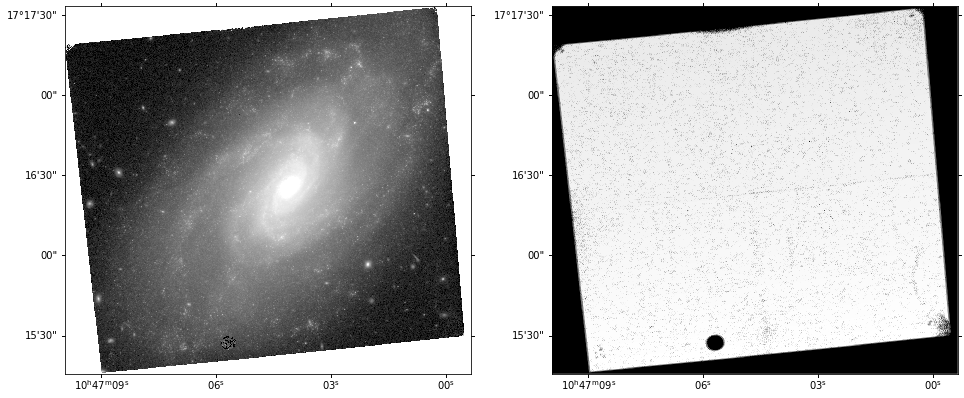

In [6]:
with fits.open('f160w_noopt_drz.fits') as hdu:
    im1wcs = wcs.WCS(hdu[1].header)
    sci1 = hdu[1].data
    wht1 = hdu[2].data
        
norm1 = ImageNormalize(sci1, vmin=-0.2, vmax=25, stretch=LogStretch())
fig, ax = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection':im1wcs})
ax[0].imshow(sci1, norm=norm1, cmap='gray', origin='lower')
ax[1].imshow(wht1, cmap='gray', origin='lower')

The drizzled science image is on the left and the associated weight image is on the right, both without optimization of the plate scale and pixfrac.

To compare, the figure plotted below shows close ups of the same part of the sky from the two drizzled products. 

(1835.4481178804988, 1934.1019662351364)

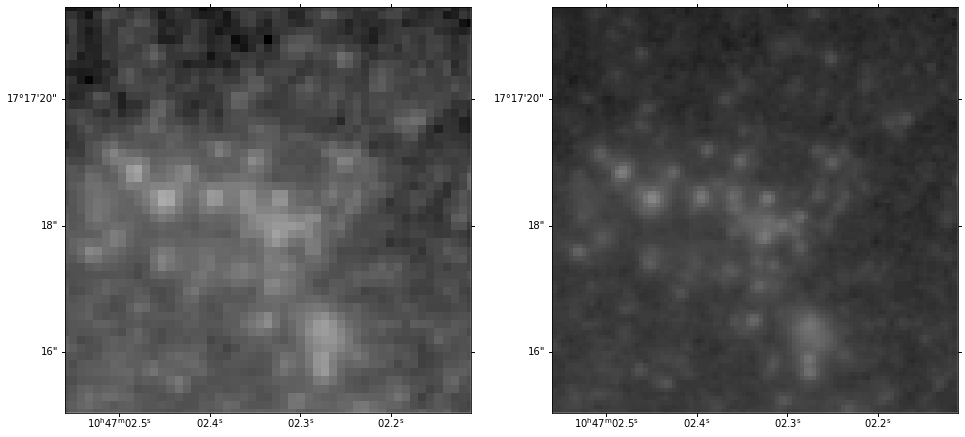

In [7]:
radeclims = wcs.utils.pixel_to_skycoord([825, 875], [930, 980], im1wcs)

with fits.open('f160w_opt_drz.fits') as hdu:
    im2wcs = wcs.WCS(hdu[1].header)
    sci2 = hdu[1].data
    wht2 = hdu[2].data

norm2 = ImageNormalize(sci2, vmin=-0.05, vmax=25, stretch=LogStretch())
    
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(1, 2, 1, projection=im1wcs)
ax.imshow(sci1, norm=norm2, cmap='gray')
ax.set_xlim(radeclims.to_pixel(im1wcs)[0])
ax.set_ylim(radeclims.to_pixel(im1wcs)[1])

ax = fig.add_subplot(1, 2, 2, projection=im2wcs)
ax.imshow(sci2, norm=norm2, cmap='gray')
ax.set_xlim(radeclims.to_pixel(im2wcs)[0])
ax.set_ylim(radeclims.to_pixel(im2wcs)[1])                  

The image on the left is without improved plate scale and pixfrac, and shows that the detector undersamples the PSF. The image on the right is the image with improved parameters where the resolution is greatly improved. 

## 5. Optimizing the `final_pixfrac` parameter

While the optimized `final_pixfrac` in the example above was chosen from experience with using a four-point dither, the value that should be used is not known *a priori*. The value could be different depending on several factors. For example, if the number of images is greater than four, the value used for `final_pixfrac` could be smaller since more images are available to fill in holes in the output grid. On the other hand, it is possible that no dithering was used during the observations. In that case, `final_pixfrac` should be left at 1.0, since shrinking the size of the drop could be detrimental. 

Below, a series of experiments will be run to determine the best `final_pixfrac` value for the selected output plate scale, by varying pixfrac in steps of 0.1 over a range of values from 0.1 to 1.0.

In [8]:
pixfracs = np.arange(0.1, 1.1, 0.1)

for pixfrac in pixfracs:
    outname = 'f160w_{:.1f}'.format(pixfrac)
    drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits',
                                         output=outname,
                                         runfile='',
                                         context=False,
                                         build=True,
                                         preserve=False,
                                         clean=True,
                                         driz_sep_bits='64,512',
                                         final_bits='64,512',
                                         final_pixfrac=pixfrac,
                                         final_wcs=True,
                                         final_rot=0.,
                                         final_scale=0.065)

No trailer file created...
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 14:17:30.385 (30/04/2019)

==== Processing Step  Initialization  started at  14:17:30.38 (30/04/2019)


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2114 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  14:17:31.21 (30/04/2019)

==== Processing Step  Static Mask  started at  14:17:31.211 (30/04/2019)
==== Processing Step  Static Mask  finished at  14:17:31.32 (30/04/2019)

==== Processing Step  Subtract Sky  started at  14:17:31.32 (30/04/2019)


***** skymatch started on 2019-04-30 14:17:31.499119
      Version 1.0.2 (2019-03-07 00:54:44 -0500)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ib1f19l6q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l6q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l7q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l7q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l9q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l9q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19laq_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19laq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lowe

   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.712918556912335 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.850577   NEW MDRIZSKY = 0.850577
   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.423691463982195 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.84582   NEW MDRIZSKY = 0.84582
***** skymatch ended on 2019-04-30 14:17:31.797772
TOTAL RUN TIME: 0:00:00.298653
==== Processing Step  Subtract Sky  finished at  14:17:31.897 (30/04/2019)

==== Processing Step  Separate Drizzle  started at  14:17:31.89 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305538169e-05  3.723829036815852e-06  
CD2_1 CD2_2  : 3.723829036815852e-06  3.542984305538169e-05  
NAXIS : 1089  963


-Generating simple FITS output: ib1f19l6q_single_sci.fits


-Generating simple FITS output: ib1f19l9q_single_sci.fits


-Generating simple FITS output: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19l6q_single_sci.fits


Writing out image to disk: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19l9q_single_wht.fits


Writing out image to disk: ib1f19l6q_single_wht.fits


-Generating simple FITS output: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19l7q_single_wht.fits


Writing out image to disk: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19laq_single_wht.fits


==== Processing Step  Separate Drizzle  finished at  14:17:32.995 (30/04/2019)

==== Processing Step  Create Median  started at  14:17:32.996 (30/04/2019)
reference sky value for image 'ib1f19l6q_flt.fits' is 465.7527079860748
reference sky value for image 'ib1f19l7q_flt.fits' is 438.310363378517
reference sky value for image 'ib1f19l9q_flt.fits' is 427.78636529492377
reference sky value for image 'ib1f19laq_flt.fits' is 425.39378312624893


Saving output median image to: 'f160w_0.1_med.fits'
==== Processing Step  Create Median  finished at  14:17:33.922 (30/04/2019)

==== Processing Step  Blot  started at  14:17:33.92 (30/04/2019)
    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step  Blot  finished at  14:17:35.785 (30/04/2019)

==== Processing Step  Driz_CR  started at  14:17:35.785 (30/04/2019)


Creating output :  ib1f19l6q_sci1_crmask.fits


Creating output :  ib1f19l7q_sci1_crmask.fits


Creating output :  ib1f19laq_sci1_crmask.fits


Creating output :  ib1f19l9q_sci1_crmask.fits


==== Processing Step  Driz_CR  finished at  14:17:36.891 (30/04/2019)

==== Processing Step  Final Drizzle  started at  14:17:36.901 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114


-Generating multi-extension output file:  f160w_0.1_drz.fits
Writing out to disk: f160w_0.1_drz.fits
==== Processing Step  Final Drizzle  finished at  14:17:39.264 (30/04/2019)


AstroDrizzle Version 2.2.6 is finished processing at 14:17:39.265 (30/04/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.8258 sec.
            Static Mask          0.1112 sec.
           Subtract Sky          0.5751 sec.
       Separate Drizzle          1.0976 sec.
          Create Median          0.9254 sec.
                   Blot          1.8630 sec.
                Driz_CR          1.1064 sec.
          Final Drizzle          2.3635 sec.
   ====================          ====================
                  Total          8.8680 sec.
No trailer file saved...
No trailer file created...
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 14:17:

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2114 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  14:17:40.085 (30/04/2019)

==== Processing Step  Static Mask  started at  14:17:40.086 (30/04/2019)
==== Processing Step  Static Mask  finished at  14:17:40.209 (30/04/2019)

==== Processing Step  Subtract Sky  started at  14:17:40.209 (30/04/2019)


***** skymatch started on 2019-04-30 14:17:40.326119
      Version 1.0.2 (2019-03-07 00:54:44 -0500)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ib1f19l6q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l6q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l7q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l7q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l9q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l9q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19laq_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19laq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lowe

   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.712918556912335 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.850577   NEW MDRIZSKY = 0.850577
   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.423691463982195 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.84582   NEW MDRIZSKY = 0.84582
***** skymatch ended on 2019-04-30 14:17:40.612781
TOTAL RUN TIME: 0:00:00.286662
==== Processing Step  Subtract Sky  finished at  14:17:40.727 (30/04/2019)

==== Processing Step  Separate Drizzle  started at  14:17:40.727 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305538169e-05  3.723829036815852e-06  
CD2_1 CD2_2  : 3.723829036815852e-06  3.542984305538169e-05  
NAXIS : 1089  963


-Generating simple FITS output: ib1f19l6q_single_sci.fits


Writing out image to disk: ib1f19l6q_single_sci.fits


Writing out image to disk: ib1f19l6q_single_wht.fits


-Generating simple FITS output: ib1f19l7q_single_sci.fits


-Generating simple FITS output: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19laq_single_sci.fits


-Generating simple FITS output: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19l7q_single_wht.fits


Writing out image to disk: ib1f19laq_single_wht.fits


Writing out image to disk: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19l9q_single_wht.fits


==== Processing Step  Separate Drizzle  finished at  14:17:41.813 (30/04/2019)

==== Processing Step  Create Median  started at  14:17:41.814 (30/04/2019)
reference sky value for image 'ib1f19l6q_flt.fits' is 465.7527079860748
reference sky value for image 'ib1f19l7q_flt.fits' is 438.310363378517
reference sky value for image 'ib1f19l9q_flt.fits' is 427.78636529492377
reference sky value for image 'ib1f19laq_flt.fits' is 425.39378312624893


Saving output median image to: 'f160w_0.2_med.fits'
==== Processing Step  Create Median  finished at  14:17:42.719 (30/04/2019)

==== Processing Step  Blot  started at  14:17:42.720 (30/04/2019)
    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step  Blot  finished at  14:17:44.494 (30/04/2019)

==== Processing Step  Driz_CR  started at  14:17:44.494 (30/04/2019)


Creating output :  ib1f19l6q_sci1_crmask.fits


Creating output :  ib1f19l7q_sci1_crmask.fits


Creating output :  ib1f19laq_sci1_crmask.fits


Creating output :  ib1f19l9q_sci1_crmask.fits


==== Processing Step  Driz_CR  finished at  14:17:45.606 (30/04/2019)

==== Processing Step  Final Drizzle  started at  14:17:45.614 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114


-Generating multi-extension output file:  f160w_0.2_drz.fits
Writing out to disk: f160w_0.2_drz.fits
==== Processing Step  Final Drizzle  finished at  14:17:47.945 (30/04/2019)


AstroDrizzle Version 2.2.6 is finished processing at 14:17:47.945 (30/04/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.7817 sec.
            Static Mask          0.1230 sec.
           Subtract Sky          0.5185 sec.
       Separate Drizzle          1.0858 sec.
          Create Median          0.9058 sec.
                   Blot          1.7740 sec.
                Driz_CR          1.1119 sec.
          Final Drizzle          2.3304 sec.
   ====================          ====================
                  Total          8.6312 sec.
No trailer file saved...
No trailer file created...
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 14:17:

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2114 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  14:17:48.839 (30/04/2019)

==== Processing Step  Static Mask  started at  14:17:48.840 (30/04/2019)
==== Processing Step  Static Mask  finished at  14:17:48.992 (30/04/2019)

==== Processing Step  Subtract Sky  started at  14:17:48.992 (30/04/2019)


***** skymatch started on 2019-04-30 14:17:49.125523
      Version 1.0.2 (2019-03-07 00:54:44 -0500)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ib1f19l6q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l6q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l7q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l7q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l9q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l9q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19laq_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19laq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lowe

   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.712918556912335 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.850577   NEW MDRIZSKY = 0.850577
   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.423691463982195 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.84582   NEW MDRIZSKY = 0.84582
***** skymatch ended on 2019-04-30 14:17:49.424384
TOTAL RUN TIME: 0:00:00.298861
==== Processing Step  Subtract Sky  finished at  14:17:49.581 (30/04/2019)

==== Processing Step  Separate Drizzle  started at  14:17:49.581 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305538169e-05  3.723829036815852e-06  
CD2_1 CD2_2  : 3.723829036815852e-06  3.542984305538169e-05  
NAXIS : 1089  963


-Generating simple FITS output: ib1f19l7q_single_sci.fits


-Generating simple FITS output: ib1f19l6q_single_sci.fits


Writing out image to disk: ib1f19l7q_single_sci.fits


-Generating simple FITS output: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19l6q_single_sci.fits


-Generating simple FITS output: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19l7q_single_wht.fits


Writing out image to disk: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19l6q_single_wht.fits


Writing out image to disk: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19laq_single_wht.fits


Writing out image to disk: ib1f19l9q_single_wht.fits


==== Processing Step  Separate Drizzle  finished at  14:17:50.635 (30/04/2019)

==== Processing Step  Create Median  started at  14:17:50.635 (30/04/2019)
reference sky value for image 'ib1f19l6q_flt.fits' is 465.7527079860748
reference sky value for image 'ib1f19l7q_flt.fits' is 438.310363378517
reference sky value for image 'ib1f19l9q_flt.fits' is 427.78636529492377
reference sky value for image 'ib1f19laq_flt.fits' is 425.39378312624893


Saving output median image to: 'f160w_0.3_med.fits'
==== Processing Step  Create Median  finished at  14:17:51.413 (30/04/2019)

==== Processing Step  Blot  started at  14:17:51.413 (30/04/2019)
    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step  Blot  finished at  14:17:53.214 (30/04/2019)

==== Processing Step  Driz_CR  started at  14:17:53.214 (30/04/2019)


Creating output :  ib1f19l6q_sci1_crmask.fits


Creating output :  ib1f19laq_sci1_crmask.fits


Creating output :  ib1f19l7q_sci1_crmask.fits


Creating output :  ib1f19l9q_sci1_crmask.fits


==== Processing Step  Driz_CR  finished at  14:17:54.382 (30/04/2019)

==== Processing Step  Final Drizzle  started at  14:17:54.391 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114


-Generating multi-extension output file:  f160w_0.3_drz.fits
Writing out to disk: f160w_0.3_drz.fits
==== Processing Step  Final Drizzle  finished at  14:17:56.862 (30/04/2019)


AstroDrizzle Version 2.2.6 is finished processing at 14:17:56.862 (30/04/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.8551 sec.
            Static Mask          0.1525 sec.
           Subtract Sky          0.5883 sec.
       Separate Drizzle          1.0537 sec.
          Create Median          0.7778 sec.
                   Blot          1.8008 sec.
                Driz_CR          1.1682 sec.
          Final Drizzle          2.4710 sec.
   ====================          ====================
                  Total          8.8674 sec.
No trailer file saved...
No trailer file created...
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 14:17:

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2114 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  14:17:57.677 (30/04/2019)

==== Processing Step  Static Mask  started at  14:17:57.678 (30/04/2019)
==== Processing Step  Static Mask  finished at  14:17:57.791 (30/04/2019)

==== Processing Step  Subtract Sky  started at  14:17:57.79 (30/04/2019)


***** skymatch started on 2019-04-30 14:17:57.906490
      Version 1.0.2 (2019-03-07 00:54:44 -0500)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ib1f19l6q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l6q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l7q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l7q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l9q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l9q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19laq_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19laq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lowe

   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.712918556912335 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.850577   NEW MDRIZSKY = 0.850577
   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.423691463982195 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.84582   NEW MDRIZSKY = 0.84582
***** skymatch ended on 2019-04-30 14:17:58.210158
TOTAL RUN TIME: 0:00:00.303668
==== Processing Step  Subtract Sky  finished at  14:17:58.322 (30/04/2019)

==== Processing Step  Separate Drizzle  started at  14:17:58.32 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305538169e-05  3.723829036815852e-06  
CD2_1 CD2_2  : 3.723829036815852e-06  3.542984305538169e-05  
NAXIS : 1089  963


-Generating simple FITS output: ib1f19l6q_single_sci.fits


-Generating simple FITS output: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19l6q_single_sci.fits


Writing out image to disk: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19l6q_single_wht.fits


-Generating simple FITS output: ib1f19l7q_single_sci.fits


-Generating simple FITS output: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19l9q_single_wht.fits


Writing out image to disk: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19l7q_single_wht.fits


Writing out image to disk: ib1f19laq_single_wht.fits


==== Processing Step  Separate Drizzle  finished at  14:17:59.411 (30/04/2019)

==== Processing Step  Create Median  started at  14:17:59.411 (30/04/2019)
reference sky value for image 'ib1f19l6q_flt.fits' is 465.7527079860748
reference sky value for image 'ib1f19l7q_flt.fits' is 438.310363378517
reference sky value for image 'ib1f19l9q_flt.fits' is 427.78636529492377
reference sky value for image 'ib1f19laq_flt.fits' is 425.39378312624893


Saving output median image to: 'f160w_0.4_med.fits'
==== Processing Step  Create Median  finished at  14:18:00.293 (30/04/2019)

==== Processing Step  Blot  started at  14:18:00.293 (30/04/2019)
    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits


Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step  Blot  finished at  14:18:02.23 (30/04/2019)

==== Processing Step  Driz_CR  started at  14:18:02.237 (30/04/2019)


Creating output :  ib1f19l6q_sci1_crmask.fits


Creating output :  ib1f19l7q_sci1_crmask.fits


Creating output :  ib1f19laq_sci1_crmask.fits


Creating output :  ib1f19l9q_sci1_crmask.fits


==== Processing Step  Driz_CR  finished at  14:18:03.799 (30/04/2019)

==== Processing Step  Final Drizzle  started at  14:18:03.814 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114


-Generating multi-extension output file:  f160w_0.4_drz.fits
Writing out to disk: f160w_0.4_drz.fits
==== Processing Step  Final Drizzle  finished at  14:18:06.666 (30/04/2019)


AstroDrizzle Version 2.2.6 is finished processing at 14:18:06.667 (30/04/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.7768 sec.
            Static Mask          0.1137 sec.
           Subtract Sky          0.5305 sec.
       Separate Drizzle          1.0882 sec.
          Create Median          0.8817 sec.
                   Blot          1.9432 sec.
                Driz_CR          1.5624 sec.
          Final Drizzle          2.8522 sec.
   ====================          ====================
                  Total          9.7487 sec.
No trailer file saved...
No trailer file created...
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 14:18:

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2114 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  14:18:07.702 (30/04/2019)

==== Processing Step  Static Mask  started at  14:18:07.702 (30/04/2019)
==== Processing Step  Static Mask  finished at  14:18:07.830 (30/04/2019)

==== Processing Step  Subtract Sky  started at  14:18:07.830 (30/04/2019)


***** skymatch started on 2019-04-30 14:18:08.037576
      Version 1.0.2 (2019-03-07 00:54:44 -0500)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ib1f19l6q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l6q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l7q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l7q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l9q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l9q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19laq_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19laq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lowe

   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.423691463982195 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.84582   NEW MDRIZSKY = 0.84582
***** skymatch ended on 2019-04-30 14:18:08.309981
TOTAL RUN TIME: 0:00:00.272405
==== Processing Step  Subtract Sky  finished at  14:18:08.427 (30/04/2019)

==== Processing Step  Separate Drizzle  started at  14:18:08.427 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305538169e-05  3.723829036815852e-06  
CD2_1 CD2_2  : 3.723829036815852e-06  3.542984305538169e-05  
NAXIS : 1089  963


-Generating simple FITS output: ib1f19l6q_single_sci.fits


Writing out image to disk: ib1f19l6q_single_sci.fits


-Generating simple FITS output: ib1f19laq_single_sci.fits


-Generating simple FITS output: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19l6q_single_wht.fits


Writing out image to disk: ib1f19laq_single_sci.fits


-Generating simple FITS output: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19l7q_single_wht.fits


Writing out image to disk: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19laq_single_wht.fits


Writing out image to disk: ib1f19l9q_single_wht.fits


==== Processing Step  Separate Drizzle  finished at  14:18:09.523 (30/04/2019)

==== Processing Step  Create Median  started at  14:18:09.523 (30/04/2019)
reference sky value for image 'ib1f19l6q_flt.fits' is 465.7527079860748
reference sky value for image 'ib1f19l7q_flt.fits' is 438.310363378517
reference sky value for image 'ib1f19l9q_flt.fits' is 427.78636529492377
reference sky value for image 'ib1f19laq_flt.fits' is 425.39378312624893


Saving output median image to: 'f160w_0.5_med.fits'
==== Processing Step  Create Median  finished at  14:18:10.27 (30/04/2019)

==== Processing Step  Blot  started at  14:18:10.278 (30/04/2019)
    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step  Blot  finished at  14:18:12.198 (30/04/2019)

==== Processing Step  Driz_CR  started at  14:18:12.198 (30/04/2019)


Creating output :  ib1f19laq_sci1_crmask.fits


Creating output :  ib1f19l6q_sci1_crmask.fits


Creating output :  ib1f19l7q_sci1_crmask.fits


Creating output :  ib1f19l9q_sci1_crmask.fits


==== Processing Step  Driz_CR  finished at  14:18:13.305 (30/04/2019)

==== Processing Step  Final Drizzle  started at  14:18:13.314 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114


-Generating multi-extension output file:  f160w_0.5_drz.fits
Writing out to disk: f160w_0.5_drz.fits
==== Processing Step  Final Drizzle  finished at  14:18:16.259 (30/04/2019)


AstroDrizzle Version 2.2.6 is finished processing at 14:18:16.259 (30/04/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.9859 sec.
            Static Mask          0.1281 sec.
           Subtract Sky          0.5970 sec.
       Separate Drizzle          1.0958 sec.
          Create Median          0.7544 sec.
                   Blot          1.9200 sec.
                Driz_CR          1.1067 sec.
          Final Drizzle          2.9446 sec.
   ====================          ====================
                  Total          9.5324 sec.
No trailer file saved...
No trailer file created...
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 14:18:

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2114 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  14:18:17.083 (30/04/2019)

==== Processing Step  Static Mask  started at  14:18:17.083 (30/04/2019)
==== Processing Step  Static Mask  finished at  14:18:17.191 (30/04/2019)

==== Processing Step  Subtract Sky  started at  14:18:17.192 (30/04/2019)


***** skymatch started on 2019-04-30 14:18:17.305139
      Version 1.0.2 (2019-03-07 00:54:44 -0500)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ib1f19l6q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l6q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l7q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l7q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l9q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l9q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19laq_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19laq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lowe

   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.712918556912335 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.850577   NEW MDRIZSKY = 0.850577
   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.423691463982195 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.84582   NEW MDRIZSKY = 0.84582
***** skymatch ended on 2019-04-30 14:18:17.589086
TOTAL RUN TIME: 0:00:00.283947
==== Processing Step  Subtract Sky  finished at  14:18:17.710 (30/04/2019)

==== Processing Step  Separate Drizzle  started at  14:18:17.710 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305538169e-05  3.723829036815852e-06  
CD2_1 CD2_2  : 3.723829036815852e-06  3.542984305538169e-05  
NAXIS : 1089  963


-Generating simple FITS output: ib1f19l6q_single_sci.fits


Writing out image to disk: ib1f19l6q_single_sci.fits


-Generating simple FITS output: ib1f19l9q_single_sci.fits


-Generating simple FITS output: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19l6q_single_wht.fits


Writing out image to disk: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19l9q_single_wht.fits


-Generating simple FITS output: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19laq_single_wht.fits


Writing out image to disk: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19l7q_single_wht.fits


==== Processing Step  Separate Drizzle  finished at  14:18:18.808 (30/04/2019)

==== Processing Step  Create Median  started at  14:18:18.80 (30/04/2019)
reference sky value for image 'ib1f19l6q_flt.fits' is 465.7527079860748
reference sky value for image 'ib1f19l7q_flt.fits' is 438.310363378517
reference sky value for image 'ib1f19l9q_flt.fits' is 427.78636529492377
reference sky value for image 'ib1f19laq_flt.fits' is 425.39378312624893


Saving output median image to: 'f160w_0.6_med.fits'
==== Processing Step  Create Median  finished at  14:18:19.598 (30/04/2019)

==== Processing Step  Blot  started at  14:18:19.598 (30/04/2019)
    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step  Blot  finished at  14:18:21.528 (30/04/2019)

==== Processing Step  Driz_CR  started at  14:18:21.528 (30/04/2019)


Creating output :  ib1f19l6q_sci1_crmask.fits


Creating output :  ib1f19l9q_sci1_crmask.fits


Creating output :  ib1f19laq_sci1_crmask.fits


Creating output :  ib1f19l7q_sci1_crmask.fits


==== Processing Step  Driz_CR  finished at  14:18:22.725 (30/04/2019)

==== Processing Step  Final Drizzle  started at  14:18:22.735 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114


-Generating multi-extension output file:  f160w_0.6_drz.fits
Writing out to disk: f160w_0.6_drz.fits
==== Processing Step  Final Drizzle  finished at  14:18:25.655 (30/04/2019)


AstroDrizzle Version 2.2.6 is finished processing at 14:18:25.65 (30/04/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.7849 sec.
            Static Mask          0.1083 sec.
           Subtract Sky          0.5178 sec.
       Separate Drizzle          1.0981 sec.
          Create Median          0.7893 sec.
                   Blot          1.9300 sec.
                Driz_CR          1.1968 sec.
          Final Drizzle          2.9203 sec.
   ====================          ====================
                  Total          9.3455 sec.
No trailer file saved...
No trailer file created...
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 14:18:2

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2114 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  14:18:26.638 (30/04/2019)

==== Processing Step  Static Mask  started at  14:18:26.638 (30/04/2019)
==== Processing Step  Static Mask  finished at  14:18:26.810 (30/04/2019)

==== Processing Step  Subtract Sky  started at  14:18:26.811 (30/04/2019)


***** skymatch started on 2019-04-30 14:18:26.986365
      Version 1.0.2 (2019-03-07 00:54:44 -0500)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ib1f19l6q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l6q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l7q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l7q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l9q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l9q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19laq_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19laq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lowe

   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.712918556912335 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.850577   NEW MDRIZSKY = 0.850577
   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.423691463982195 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.84582   NEW MDRIZSKY = 0.84582
***** skymatch ended on 2019-04-30 14:18:27.328107
TOTAL RUN TIME: 0:00:00.341742


==== Processing Step  Subtract Sky  finished at  14:18:27.487 (30/04/2019)

==== Processing Step  Separate Drizzle  started at  14:18:27.487 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305538169e-05  3.723829036815852e-06  
CD2_1 CD2_2  : 3.723829036815852e-06  3.542984305538169e-05  
NAXIS : 1089  963


-Generating simple FITS output: ib1f19l6q_single_sci.fits


-Generating simple FITS output: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19l6q_single_sci.fits


Writing out image to disk: ib1f19laq_single_sci.fits


-Generating simple FITS output: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19l6q_single_wht.fits


Writing out image to disk: ib1f19l9q_single_sci.fits


-Generating simple FITS output: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19laq_single_wht.fits


Writing out image to disk: ib1f19l9q_single_wht.fits


Writing out image to disk: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19l7q_single_wht.fits


==== Processing Step  Separate Drizzle  finished at  14:18:28.534 (30/04/2019)

==== Processing Step  Create Median  started at  14:18:28.534 (30/04/2019)
reference sky value for image 'ib1f19l6q_flt.fits' is 465.7527079860748
reference sky value for image 'ib1f19l7q_flt.fits' is 438.310363378517
reference sky value for image 'ib1f19l9q_flt.fits' is 427.78636529492377
reference sky value for image 'ib1f19laq_flt.fits' is 425.39378312624893


Saving output median image to: 'f160w_0.7_med.fits'
==== Processing Step  Create Median  finished at  14:18:29.509 (30/04/2019)

==== Processing Step  Blot  started at  14:18:29.510 (30/04/2019)
    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step  Blot  finished at  14:18:31.437 (30/04/2019)

==== Processing Step  Driz_CR  started at  14:18:31.437 (30/04/2019)


Creating output :  ib1f19l9q_sci1_crmask.fits


Creating output :  ib1f19l6q_sci1_crmask.fits


Creating output :  ib1f19laq_sci1_crmask.fits


Creating output :  ib1f19l7q_sci1_crmask.fits


==== Processing Step  Driz_CR  finished at  14:18:32.614 (30/04/2019)

==== Processing Step  Final Drizzle  started at  14:18:32.625 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114


-Generating multi-extension output file:  f160w_0.7_drz.fits
Writing out to disk: f160w_0.7_drz.fits
==== Processing Step  Final Drizzle  finished at  14:18:36.048 (30/04/2019)


AstroDrizzle Version 2.2.6 is finished processing at 14:18:36.048 (30/04/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.9373 sec.
            Static Mask          0.1719 sec.
           Subtract Sky          0.6758 sec.
       Separate Drizzle          1.0469 sec.
          Create Median          0.9750 sec.
                   Blot          1.9270 sec.
                Driz_CR          1.1770 sec.
          Final Drizzle          3.4231 sec.
   ====================          ====================
                  Total          10.3339 sec.


No trailer file saved...
No trailer file created...
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 14:18:36.101 (30/04/2019)

==== Processing Step  Initialization  started at  14:18:36.1 (30/04/2019)


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2114 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  14:18:37.201 (30/04/2019)

==== Processing Step  Static Mask  started at  14:18:37.202 (30/04/2019)
==== Processing Step  Static Mask  finished at  14:18:37.339 (30/04/2019)

==== Processing Step  Subtract Sky  started at  14:18:37.340 (30/04/2019)


***** skymatch started on 2019-04-30 14:18:37.504851
      Version 1.0.2 (2019-03-07 00:54:44 -0500)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ib1f19l6q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l6q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l7q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l7q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l9q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l9q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19laq_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19laq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lowe

   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.712918556912335 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.850577   NEW MDRIZSKY = 0.850577
   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.423691463982195 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.84582   NEW MDRIZSKY = 0.84582
***** skymatch ended on 2019-04-30 14:18:37.807404
TOTAL RUN TIME: 0:00:00.302553


==== Processing Step  Subtract Sky  finished at  14:18:37.980 (30/04/2019)

==== Processing Step  Separate Drizzle  started at  14:18:37.981 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305538169e-05  3.723829036815852e-06  
CD2_1 CD2_2  : 3.723829036815852e-06  3.542984305538169e-05  
NAXIS : 1089  963


-Generating simple FITS output: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19laq_single_sci.fits


-Generating simple FITS output: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19laq_single_wht.fits


-Generating simple FITS output: ib1f19l7q_single_sci.fits


-Generating simple FITS output: ib1f19l6q_single_sci.fits


Writing out image to disk: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19l9q_single_wht.fits


Writing out image to disk: ib1f19l6q_single_sci.fits


Writing out image to disk: ib1f19l7q_single_wht.fits


Writing out image to disk: ib1f19l6q_single_wht.fits


==== Processing Step  Separate Drizzle  finished at  14:18:39.021 (30/04/2019)

==== Processing Step  Create Median  started at  14:18:39.021 (30/04/2019)
reference sky value for image 'ib1f19l6q_flt.fits' is 465.7527079860748
reference sky value for image 'ib1f19l7q_flt.fits' is 438.310363378517
reference sky value for image 'ib1f19l9q_flt.fits' is 427.78636529492377
reference sky value for image 'ib1f19laq_flt.fits' is 425.39378312624893


Saving output median image to: 'f160w_0.8_med.fits'
==== Processing Step  Create Median  finished at  14:18:39.875 (30/04/2019)

==== Processing Step  Blot  started at  14:18:39.876 (30/04/2019)
    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step  Blot  finished at  14:18:41.686 (30/04/2019)

==== Processing Step  Driz_CR  started at  14:18:41.68 (30/04/2019)


Creating output :  ib1f19l9q_sci1_crmask.fits


Creating output :  ib1f19l6q_sci1_crmask.fits


Creating output :  ib1f19laq_sci1_crmask.fits


Creating output :  ib1f19l7q_sci1_crmask.fits


==== Processing Step  Driz_CR  finished at  14:18:42.788 (30/04/2019)

==== Processing Step  Final Drizzle  started at  14:18:42.79 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114


-Generating multi-extension output file:  f160w_0.8_drz.fits
Writing out to disk: f160w_0.8_drz.fits
==== Processing Step  Final Drizzle  finished at  14:18:46.07 (30/04/2019)


AstroDrizzle Version 2.2.6 is finished processing at 14:18:46.073 (30/04/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.0998 sec.
            Static Mask          0.1373 sec.
           Subtract Sky          0.6408 sec.
       Separate Drizzle          1.0399 sec.
          Create Median          0.8541 sec.
                   Blot          1.8098 sec.
                Driz_CR          1.1018 sec.
          Final Drizzle          3.2766 sec.
   ====================          ====================
                  Total          9.9600 sec.
No trailer file saved...
No trailer file created...
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 14:18:4

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2114 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  14:18:46.888 (30/04/2019)

==== Processing Step  Static Mask  started at  14:18:46.888 (30/04/2019)
==== Processing Step  Static Mask  finished at  14:18:47.015 (30/04/2019)

==== Processing Step  Subtract Sky  started at  14:18:47.016 (30/04/2019)


***** skymatch started on 2019-04-30 14:18:47.188187
      Version 1.0.2 (2019-03-07 00:54:44 -0500)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ib1f19l6q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l6q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l7q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l7q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l9q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l9q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19laq_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19laq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lowe

   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.712918556912335 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.850577   NEW MDRIZSKY = 0.850577
   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.423691463982195 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.84582   NEW MDRIZSKY = 0.84582
***** skymatch ended on 2019-04-30 14:18:47.494433
TOTAL RUN TIME: 0:00:00.306246
==== Processing Step  Subtract Sky  finished at  14:18:47.608 (30/04/2019)

==== Processing Step  Separate Drizzle  started at  14:18:47.609 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305538169e-05  3.723829036815852e-06  
CD2_1 CD2_2  : 3.723829036815852e-06  3.542984305538169e-05  
NAXIS : 1089  963


-Generating simple FITS output: ib1f19l6q_single_sci.fits


-Generating simple FITS output: ib1f19l9q_single_sci.fits


-Generating simple FITS output: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19l6q_single_sci.fits


Writing out image to disk: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19l6q_single_wht.fits


Writing out image to disk: ib1f19l9q_single_wht.fits


Writing out image to disk: ib1f19laq_single_wht.fits


-Generating simple FITS output: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19l7q_single_wht.fits


==== Processing Step  Separate Drizzle  finished at  14:18:48.700 (30/04/2019)

==== Processing Step  Create Median  started at  14:18:48.70 (30/04/2019)
reference sky value for image 'ib1f19l6q_flt.fits' is 465.7527079860748
reference sky value for image 'ib1f19l7q_flt.fits' is 438.310363378517
reference sky value for image 'ib1f19l9q_flt.fits' is 427.78636529492377
reference sky value for image 'ib1f19laq_flt.fits' is 425.39378312624893


Saving output median image to: 'f160w_0.9_med.fits'
==== Processing Step  Create Median  finished at  14:18:49.595 (30/04/2019)

==== Processing Step  Blot  started at  14:18:49.59 (30/04/2019)
    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step  Blot  finished at  14:18:51.420 (30/04/2019)

==== Processing Step  Driz_CR  started at  14:18:51.420 (30/04/2019)


Creating output :  ib1f19l7q_sci1_crmask.fits


Creating output :  ib1f19laq_sci1_crmask.fits


Creating output :  ib1f19l9q_sci1_crmask.fits


Creating output :  ib1f19l6q_sci1_crmask.fits


==== Processing Step  Driz_CR  finished at  14:18:52.896 (30/04/2019)

==== Processing Step  Final Drizzle  started at  14:18:52.905 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114


-Generating multi-extension output file:  f160w_0.9_drz.fits
Writing out to disk: f160w_0.9_drz.fits
==== Processing Step  Final Drizzle  finished at  14:18:56.3 (30/04/2019)




AstroDrizzle Version 2.2.6 is finished processing at 14:18:56.32 (30/04/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.7743 sec.
            Static Mask          0.1277 sec.
           Subtract Sky          0.5928 sec.
       Separate Drizzle          1.0906 sec.
          Create Median          0.8950 sec.
                   Blot          1.8250 sec.
                Driz_CR          1.4755 sec.
          Final Drizzle          3.4204 sec.
   ====================          ====================
                  Total          10.2012 sec.
No trailer file saved...
No trailer file created...
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 14:18:56.365 (30/04/2019)

==== Processing Step  Initialization  started at  14:18:56.365 (30/04/2019)


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2114 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  14:18:57.131 (30/04/2019)

==== Processing Step  Static Mask  started at  14:18:57.131 (30/04/2019)
==== Processing Step  Static Mask  finished at  14:18:57.224 (30/04/2019)

==== Processing Step  Subtract Sky  started at  14:18:57.224 (30/04/2019)


***** skymatch started on 2019-04-30 14:18:57.377992
      Version 1.0.2 (2019-03-07 00:54:44 -0500)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ib1f19l6q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l6q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l7q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l7q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19l9q_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19l9q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ib1f19laq_flt.fits'
       EXT: 'SCI',1;	MASK: ib1f19laq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lowe

   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.423691463982195 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.84582   NEW MDRIZSKY = 0.84582
***** skymatch ended on 2019-04-30 14:18:57.618810
TOTAL RUN TIME: 0:00:00.240818
==== Processing Step  Subtract Sky  finished at  14:18:57.712 (30/04/2019)

==== Processing Step  Separate Drizzle  started at  14:18:57.713 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305538169e-05  3.723829036815852e-06  
CD2_1 CD2_2  : 3.723829036815852e-06  3.542984305538169e-05  
NAXIS : 1089  963


-Generating simple FITS output: ib1f19l7q_single_sci.fits


-Generating simple FITS output: ib1f19l6q_single_sci.fits


Writing out image to disk: ib1f19l7q_single_sci.fits


Writing out image to disk: ib1f19l7q_single_wht.fits


-Generating simple FITS output: ib1f19laq_single_sci.fits


Writing out image to disk: ib1f19l6q_single_sci.fits


Writing out image to disk: ib1f19laq_single_sci.fits


-Generating simple FITS output: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19l6q_single_wht.fits


Writing out image to disk: ib1f19laq_single_wht.fits


Writing out image to disk: ib1f19l9q_single_sci.fits


Writing out image to disk: ib1f19l9q_single_wht.fits


==== Processing Step  Separate Drizzle  finished at  14:18:58.811 (30/04/2019)

==== Processing Step  Create Median  started at  14:18:58.812 (30/04/2019)
reference sky value for image 'ib1f19l6q_flt.fits' is 465.7527079860748
reference sky value for image 'ib1f19l7q_flt.fits' is 438.310363378517
reference sky value for image 'ib1f19l9q_flt.fits' is 427.78636529492377
reference sky value for image 'ib1f19laq_flt.fits' is 425.39378312624893


Saving output median image to: 'f160w_1.0_med.fits'
==== Processing Step  Create Median  finished at  14:18:59.626 (30/04/2019)

==== Processing Step  Blot  started at  14:18:59.626 (30/04/2019)
    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step  Blot  finished at  14:19:01.490 (30/04/2019)

==== Processing Step  Driz_CR  started at  14:19:01.490 (30/04/2019)


Creating output :  ib1f19l7q_sci1_crmask.fits


Creating output :  ib1f19l6q_sci1_crmask.fits


Creating output :  ib1f19l9q_sci1_crmask.fits


Creating output :  ib1f19laq_sci1_crmask.fits


==== Processing Step  Driz_CR  finished at  14:19:02.593 (30/04/2019)

==== Processing Step  Final Drizzle  started at  14:19:02.602 (30/04/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.76939966928876  17.273430525939578  
CRPIX : 1167.3829659129597  1056.5471233907554  
CD1_1 CD1_2  : -1.805555555555555e-05  3.6939273646322496e-22  
CD2_1 CD2_2  : 3.702614723534622e-22  1.805555555555555e-05  
NAXIS : 2336  2114


-Generating multi-extension output file:  f160w_1.0_drz.fits
Writing out to disk: f160w_1.0_drz.fits
==== Processing Step  Final Drizzle  finished at  14:19:06.21 (30/04/2019)


AstroDrizzle Version 2.2.6 is finished processing at 14:19:06.214 (30/04/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.7662 sec.
            Static Mask          0.0929 sec.
           Subtract Sky          0.4880 sec.
       Separate Drizzle          1.0984 sec.
          Create Median          0.8140 sec.
                   Blot          1.8633 sec.
                Driz_CR          1.1036 sec.
          Final Drizzle          3.6120 sec.
   ====================          ====================
                  Total          9.8384 sec.
No trailer file saved...


When evaluating what value to use for `final_pixfrac`, *THERE IS NO SINGLE METRIC THAT INDICATES WHAT VALUE TO USE*, and several factors should be taken into account. The general philosophy is that the chosen value should improve the resolution of the image as much as possible, without causing any adverse effects. 

The first thing to look for is an excessive number of holes in the science and weight images. The figure below shows the central region of the science and weight images produced by three different `final_pixfrac` values.

(1835.4481178804988, 1934.1019662351364)

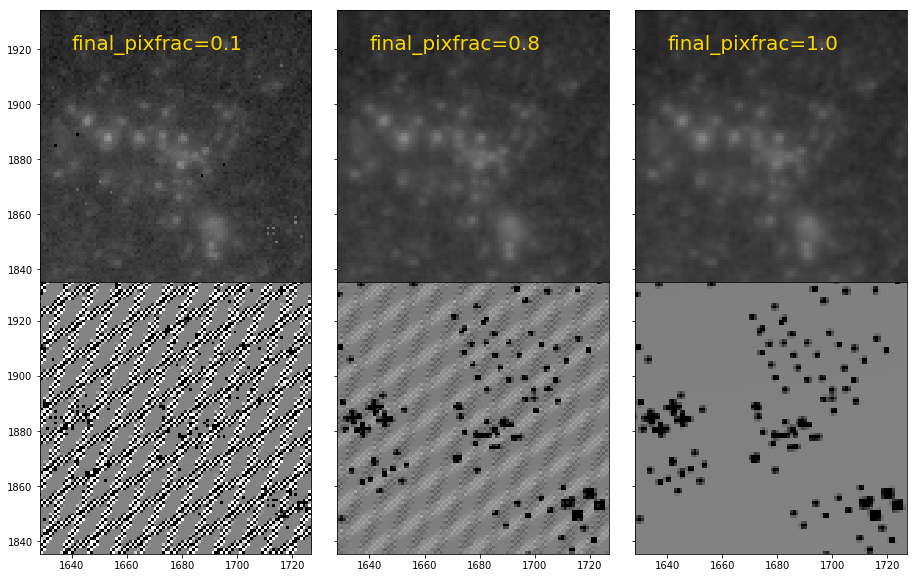

In [9]:
with fits.open('f160w_0.1_drz.fits') as hdu1:
    sci1 = hdu1[1].data
    wht1 = hdu1[2].data
    
with fits.open('f160w_0.8_drz.fits') as hdu2:
    sci2 = hdu2[1].data
    wht2 = hdu2[2].data
    
with fits.open('f160w_1.0_drz.fits') as hdu3:
    sci3 = hdu3[1].data
    wht3 = hdu3[2].data

fig,ax = plt.subplots(2, 3, figsize=(16, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

norm3 = ImageNormalize(wht2, vmin=400, vmax=600, stretch=LinearStretch())
ax[0, 0].imshow(sci1, norm=norm2, cmap='gray')
ax[0, 0].text(1640, 1920, 'final_pixfrac=0.1', fontsize='20', color='gold')
ax[0, 1].imshow(sci2, norm=norm2, cmap='gray')
ax[0, 1].text(1640, 1920, 'final_pixfrac=0.8', fontsize='20', color='gold')
ax[0, 2].imshow(sci3, norm=norm2, cmap='gray')
ax[0, 2].text(1640, 1920, 'final_pixfrac=1.0', fontsize='20', color='gold')
ax[1, 0].imshow(wht1, norm=norm3, cmap='gray')
ax[1, 1].imshow(wht2, norm=norm3, cmap='gray')
ax[1, 2].imshow(wht3, norm=norm3, cmap='gray')
ax[0, 0].set_xlim(radeclims.to_pixel(im2wcs)[0])
ax[0, 0].set_ylim(radeclims.to_pixel(im2wcs)[1])

This figure above shows the central region of the science and weight images produced by `final_pixfrac` values (left to right) of 0.1, 0.8 and 1.0. The top row is the science frame, the bottom is the weight image. The science image with the smallest `final_pixfrac` value of 0.1 shows a noisy background and holes in the image where no input pixels fall into the output grid because pixfrac is too small. Inspection of the weight map corresponding to the smallest `final_pixfrac` value shows many places with weights of zero, indicating that a `final_pixfrac` value of 0.1 is clearly too small and was only included in this example for illustrative purposes.

Another piece of information that can be useful is the amount of noise in the weight image. As suggested in the [HST Dither Handbook](http://www.stsci.edu/hst/HST_overview/documents/dither_handbook) Chapter 5 and in the [DrizzlePac Handbook](http://documents.stsci.edu/hst/HST_overview/documents/DrizzlePac/ch64.html#586267) Section 6.3.3, statistics performed on the drizzled weight image should yield a RMS/median value less than ~0.2. This threshold controls the trade-off between improving image resolution versus increasing background noise due to pixel resampling.
 
The figure below shows the RMS/median as a function of `final_pixfrac`. One should take care to use the same region in the weight image as the region where the object of interest is located in the science image. If one is using the entire image for scientific analysis, then one should measure the statistics of the weight image where there is more variance. 

Text(0.1, 0.35, '4 images')

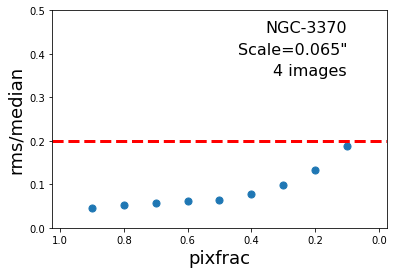

In [10]:
whtlist = glob.glob('f160w_0.[0-9]*drz.fits')

std_med = np.empty(len(whtlist), dtype=float)
fraclist = np.empty(len(whtlist), dtype=float)
xlims = radeclims.to_pixel(im1wcs)[0].astype(int)
ylims = radeclims.to_pixel(im1wcs)[1].astype(int)

#Loop that measures statistics, also some information gathering
for i, im in enumerate(whtlist):
    with fits.open(im) as hdu:
        hdr = hdu[0].header
        wht = hdu[2].data
    if i == 0:
        target = hdr['TARGNAME']
        scale = str(hdr['D001SCAL'])
        nimg = hdr['NDRIZIM']
    wht_std = np.std(wht[ylims[0] : ylims[1], xlims[0] : xlims[1]])
    wht_med = np.median(wht[ylims[0] : ylims[1], xlims[0] : xlims[1]])
    std_med[i] = wht_std / wht_med
    fraclist[i] = hdr['D001PIXF']

#Plotting commands              
plt.clf()
plt.xlim(1.025, -0.025)
plt.ylim(0., 0.5)
plt.scatter(fraclist, std_med, s=50)
plt.axhline(0.2, ls='--', lw=3, c='r')
plt.xlabel('pixfrac', fontsize=18)
plt.ylabel('rms/median', fontsize=18)
plt.text(0.1, 0.45, target, fontsize=16, horizontalalignment='right')
plt.text(0.1, 0.40, 'Scale=' + str(scale) + '"', fontsize=16, horizontalalignment='right')
plt.text(0.1, 0.35, str(nimg) + ' images', fontsize=16, horizontalalignment='right')

The RMS/median increases steadily up to pixfrac of 0.6, where there is a change in the slope of the function, indicating that something odd might be happening beyond that point. Even though the RMS remains below 20% of the median all the way to `final_pixfrac` of 0.1, the higher slope in the curve combined with the information from inspection of the science images themselvse (the evidence of holes) indicates that the pixfrac should remain >0.6. 

## 6. Final thoughts

The `final_pixfrac` value has to be small enough to avoid degrading the combined output image, but large enough that when all images are "dropped" onto the final frame, coverage of the output frame is fairly uniform. In general, `final_pixfrac` should be slightly larger than the final output scale to allow some "spillover" to adjacent pixels. This will help avoid "holes" in the final product when a given pixel has been flagged as "bad" in several frames. As a rule of thumb, statistics performed on the drizzled weight image in the region of interest should yield an RMS value (standard deviation) that is less than 20% of the median value. This threshold is a balance between the benefits of improving the image resolution at the expense of increasing noise in the background.

## About this Notebook

    Author: R. Avila, STScI ACS Team  
    Updated: December 12, 2018